In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV,TimeSeriesSplit
from catboost import Pool, CatBoostRegressor,cv
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

pd.options.display.float_format = '{:,.2f}'.format

# Задача
Спрогнозировать количество заказов такси в период пиковой нагрузки на следующий час для того чтобы привлекать больше водителей 
## Цель:
- Загрузить данные и выполнить их ресемплирование по одному часу.
- Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.

- Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Подготовка

In [2]:
data = pd.read_csv(r'C:\Users\Integro\Desktop\Обучение\YandexPracticum\Sprint 11\taxi.csv',parse_dates=[0],index_col =[0])
# data = pd.read_csv('/datasets/taxi.csv',parse_dates=[0],index_col =[0])
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


**Комментарий:** данные за каждые 10 мин

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


## Анализ

Данные  за 6 месяцев 2018

In [4]:
data_pivot = data.resample('1M').mean()
data_pivot

,num_orders
datetime,
2018-03-31,9.58
2018-04-30,10.63
2018-05-31,12.28
2018-06-30,13.87
2018-07-31,16.67
2018-08-31,21.28


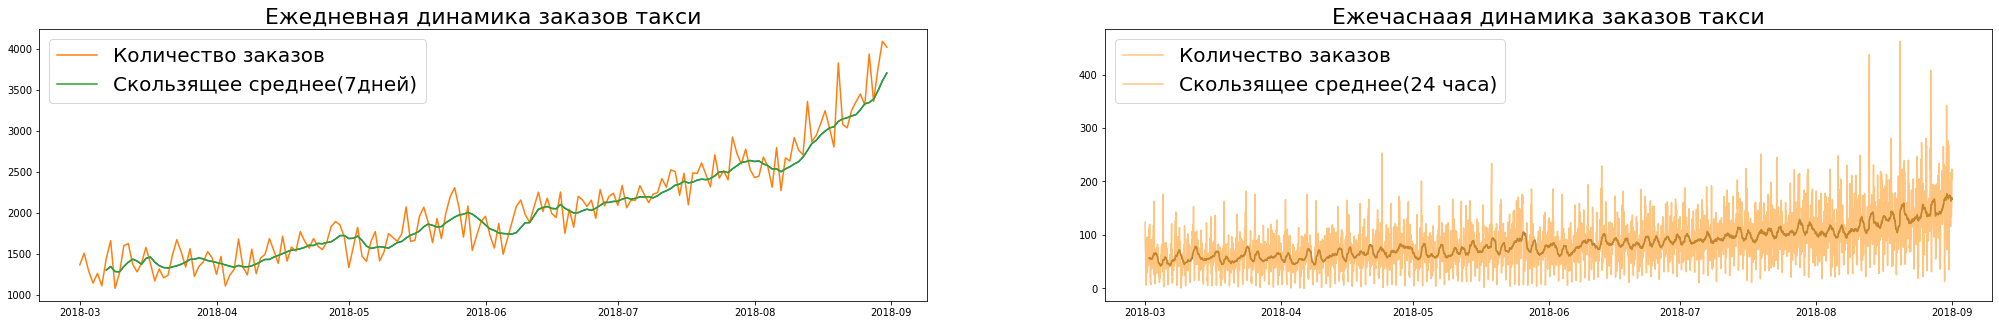

In [5]:

data.sort_index(inplace=True)
data_1d =data.copy()
data_1h =data.copy()
fig, axes = plt.subplots(1, 2,figsize=(35, 5));

data_1d = data_1d.resample('1D').sum()
data_1h = data_1h.resample('1H').sum()

data_1d['rolling_mean'] = data_1d.rolling(7).mean()
data_1h['rolling_mean'] = data_1h.rolling(24).mean()

axes[0].plot(data_1d['rolling_mean']);
axes[0].plot(data_1d, label=['Количество заказов','Скользящее среднее(7дней)'])
axes[0].set_title('Ежедневная динамика заказов такси', fontsize=22)
axes[0].legend(loc='upper left',fontsize=20);

axes[1].plot(data_1h['rolling_mean']);
axes[1].plot(data_1h,alpha=0.5,color="darkorange",label=['Количество заказов','Скользящее среднее(24 часа)']);
axes[1].set_title('Ежечаснаая динамика заказов такси', fontsize=22)
axes[1].legend(loc='upper left',fontsize=20);


**Комментарий:** В течение анализируемого периода март - август 2018 сформирован тренд роста  заказов. В течение полугода рост заказов вырос в 2,2 раза. В особенности сильный рост сформирован  в  августе 2018. Целесообразно проанализировать причину роста более детально. Рассмотреть недельные и  дневные срезы.

In [6]:
data_decomposed = data.resample('1H').sum()
data_decomposed.sort_index(inplace=True)
decomposed = seasonal_decompose(data_decomposed)

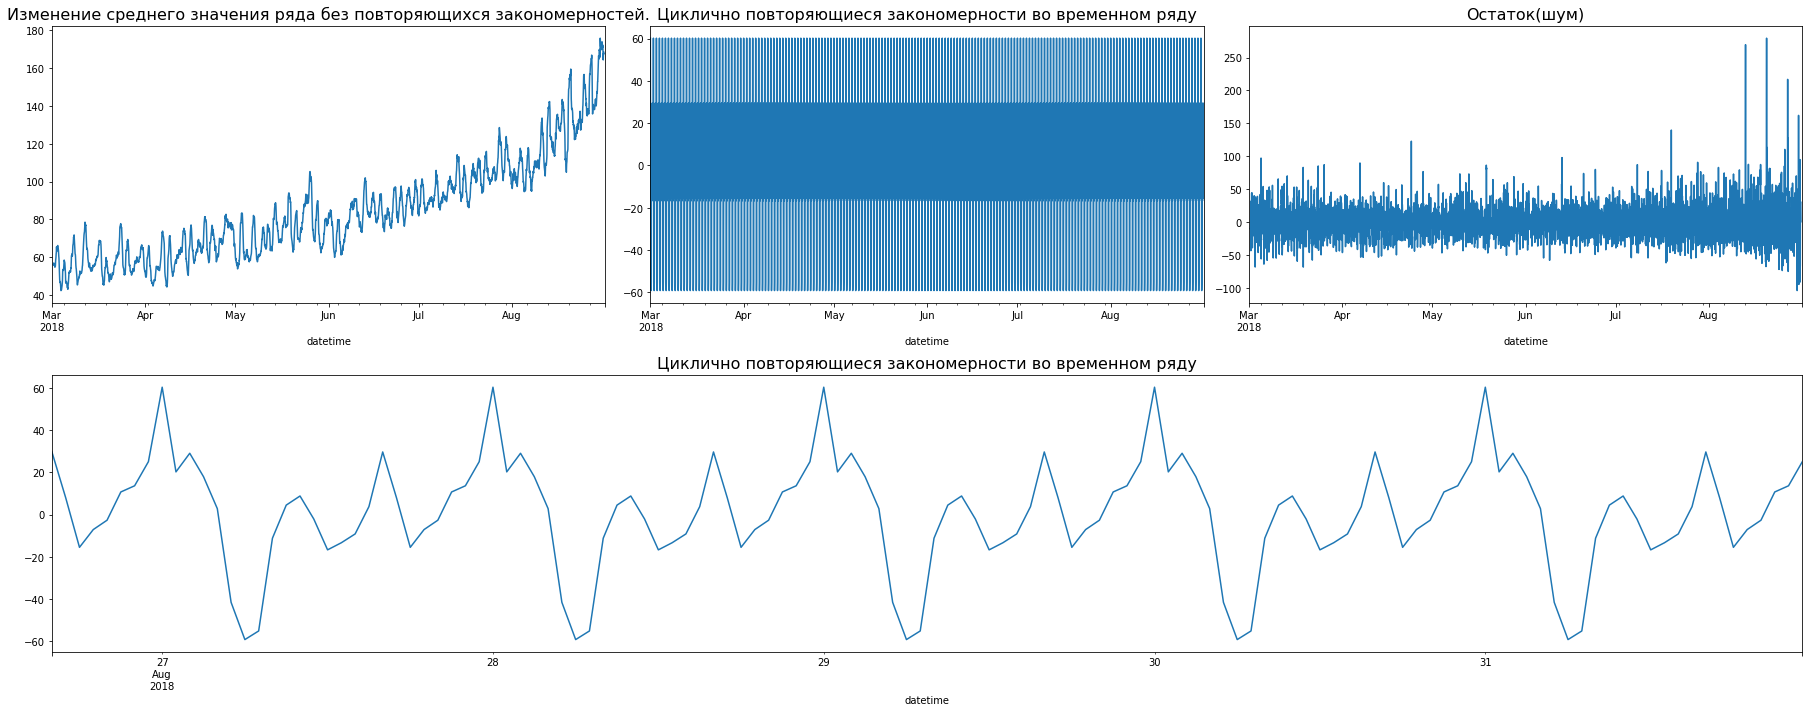

In [7]:
plt.figure(figsize=(25, 10))

plt.subplot(231)
decomposed.trend.plot(ax=plt.gca())
plt.title('Изменение среднего значения ряда без повторяющихся закономерностей.', fontsize=16)

plt.subplot(232)
decomposed.seasonal .plot(ax=plt.gca())
plt.title('Циклично повторяющиеся закономерности во временном ряду',fontsize=16)

plt.subplot(233)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток(шум)',fontsize=16)

plt.subplot(212)
decomposed.seasonal[-128:] .plot(ax=plt.gca())
plt.title('Циклично повторяющиеся закономерности во временном ряду',fontsize=16)

plt.tight_layout()

**Комментарий:** Цикличной закономерностью можно выделить неделю

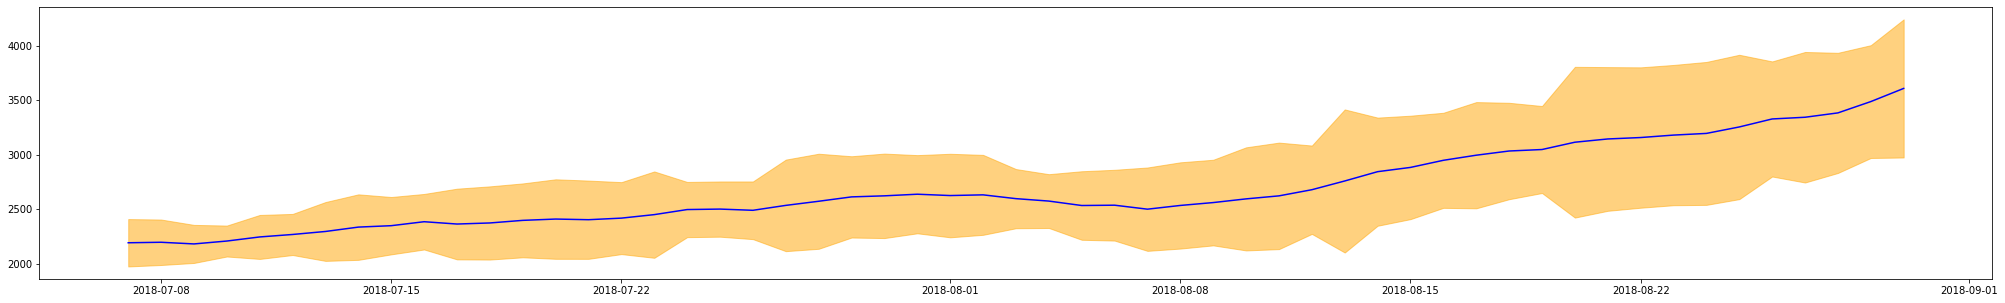

In [8]:
fig, axes = plt.subplots(figsize=(35, 5));
data_1d = data_1d['2018-07-01':'2018-08-30']
data_1d['std'] = data_1d['num_orders'].rolling(7).std()
axes.fill_between(data_1d['rolling_mean'].index, data_1d['rolling_mean'] - 2 * data_1d['std'], data_1d['rolling_mean'] + 2 * data_1d['std'], color="orange", alpha=0.5);
axes.plot(data_1d['2018-07-07':'2018-08-30']['rolling_mean'].index,data_1d['2018-07-07':'2018-08-30']['rolling_mean'], "b");

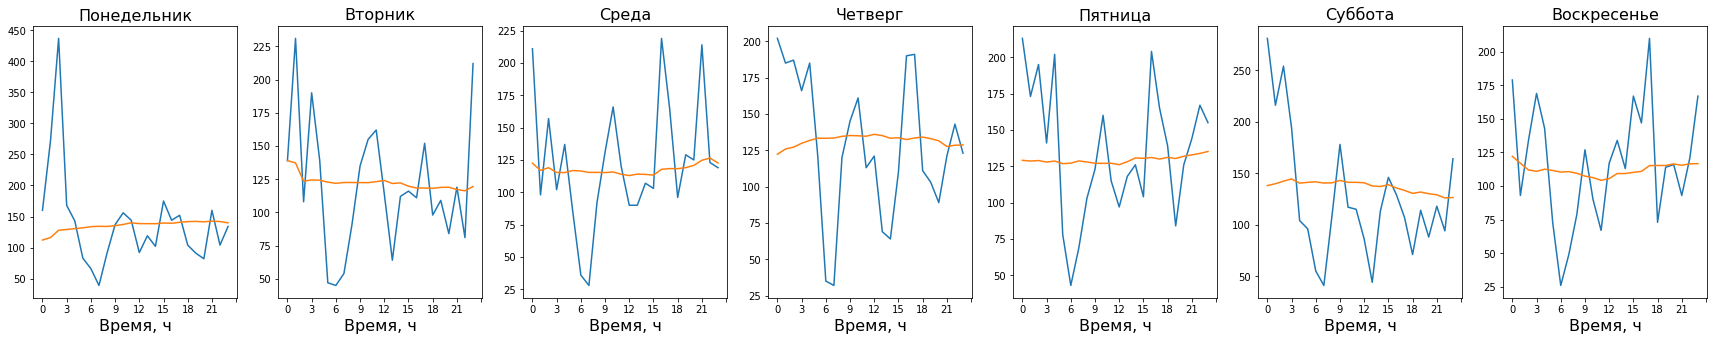

In [9]:
import matplotlib.ticker as mticker
list_week = data_1h['2018-08-13':'2018-08-19']
list_title =['Понедельник', 'Вторник','Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
values_list=list(range(0,24,3))
fig, axes = plt.subplots(1, 7,figsize=(30, 5))

for i in range(1,8):
    axes[i-1].plot(list_week[i*24-24:i*24]);
    axes[i-1].set_title(list_title[i-1], fontsize=16)
    axes[i-1].set_xticklabels(list(range(0,24,3)))
    axes[i-1].set_xlabel('Время, ч', fontsize=16) 

**Вывод:** В целом, если  разобрать тенденции, то отчетливо видно, что спрос формируется в период деловой активности населения.
- Падение спроса ну услуги такси происходит в утренние часы 3-6 утра, с 12-15 послеобеденное время, с 18-21 вечернее время.
- Рост спроса  на такси сформирован в ночное время, скорее всего, по причине  отсутствия общественного транспорта, утреннее время начало деловой активности населения и полуденное время второй  период дня деловой активности.


## Обучение

### Создание функции лаговых  переменных

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    df_copy = data.copy().resample('1H').sum()
    df_copy['dayofweek'] = df_copy.index.dayofweek
    df_copy['day'] = df_copy.index.day
    df_copy['hour'] = df_copy.index.hour
    
    for lag in range(1, max_lag + 1):
        df_copy['lag_{}'.format(lag)] = df_copy['num_orders'].shift(lag)

    df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df_copy

In [11]:
# df_copy = data.copy().resample('1H').sum()

df_copy = make_features(data, 3, 2)
train, test = train_test_split(df_copy, test_size=0.1, shuffle=False)
train = train.dropna()
test = test.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

### Создание переменной для кросс-валидации

Применим TimeSeriesSplit для того , чтобы при кросс-валидавции тест строго следовал за окончанием трейн.

In [12]:
tscv = TimeSeriesSplit(n_splits=10)

### Проверка корректности
разделения выборок.

In [13]:
display(
    features_train.shape,
    target_train.shape,
    features_test.shape,
    target_test.shape
)

(3971, 7)

(3971,)

(442, 7)

(442,)

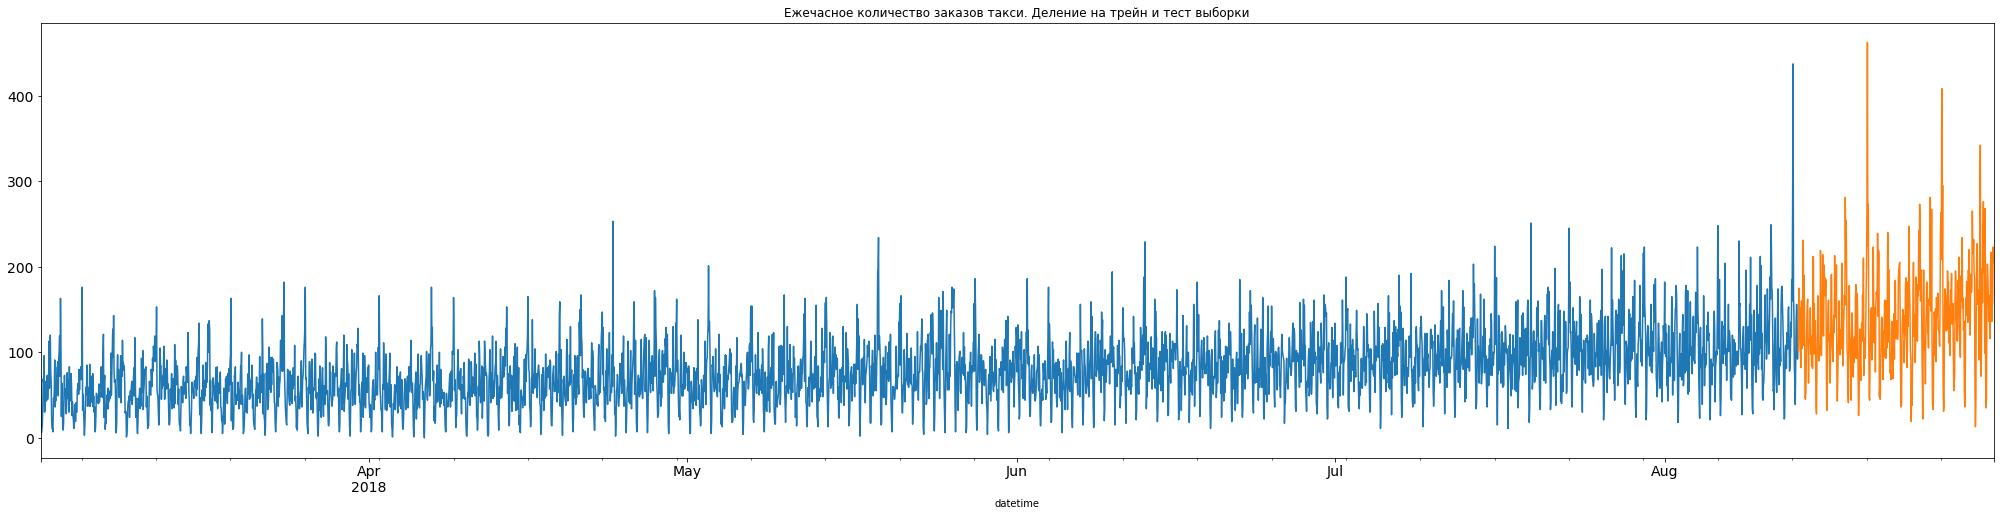

In [14]:
train['num_orders'].plot(figsize=(35,8), title= 'Ежечасное количество заказов такси. Деление на трейн и тест выборки', fontsize=14)
test['num_orders'].plot(figsize=(35,8), fontsize=14)
plt.show()

**Комментарий:** как мы видим разбиение на трейн и тест произошло корректно, то есть последовательно, так как перемешивание данны недопустимо

### Создадим функцию создания датасета и  лаговых переменных

In [15]:
features_train.shape

(3971, 7)

In [16]:
def data_prepare(df,best_lag,best_time_window):

    df_copy = make_features(df, best_lag, best_time_window)
    train, test = train_test_split(df_copy, test_size=0.1, shuffle=False)
    train = train.dropna()
    test = test.dropna()
    features_train = train.drop('num_orders', axis=1)
    target_train = train['num_orders']
    features_test = test.drop('num_orders', axis=1)
    target_test = test['num_orders']
    return train,test, features_train, target_train, features_test, target_test

### LinearRegression

In [17]:
lr = LinearRegression()
tscv = TimeSeriesSplit(n_splits=10)
rmse_lr_cv = cross_val_score(lr,features_train,target_train,n_jobs = -1,cv = tscv, scoring = 'neg_root_mean_squared_error').mean()*(-1)
print('Корень среднего квадрата ошибки {:.2f}'.format(rmse_lr_cv))

Корень среднего квадрата ошибки 32.10


In [18]:
lr.fit(features_train, target_train)
pred_valid = lr.predict(features_test)
rmse_lr = mean_squared_error(target_test, pred_valid, squared=False)
print('Корень квадрата ошибки {:.2f}'.format(rmse_lr))


Корень квадрата ошибки 56.23


RMSE недостаточно для достижения целевого показтеля  задачи.

### Оценка количества лаговых переменных на качество линейной модели.

Обучим и измерим изменение RMSE исходя из изменения количества лагов и временного окна.

In [19]:
%%time
# df_copy = data.copy().resample('1H').sum()

quantity_lag = list(range(12,336,24))
time_window = list(range(12,336,12))

best_rmse =30000
best_lag =0
best_time_window = 0
print('Устаешь ждать, но насколько хуже было бы, если бы ждать стало нечего(ждать минуты три,четыре)')

for lag in quantity_lag:
    for window in time_window:
        train,test,features_train, target_train, features_test, target_test = data_prepare(data,lag,window)
        lr = LinearRegression()
        rmse_lr_cv = cross_val_score(lr,features_train,target_train,n_jobs = -1,cv = tscv, scoring = 'neg_root_mean_squared_error').mean()*(-1)

#         print('Корень среднего квадрата ошибки {:.2f}'.format(rmse_lr_cv),  'Количество временных лагов {}'.format(lag),'Временное окно {},ч'.format(window) )

        if rmse_lr_cv < best_rmse:
            best_rmse =rmse_lr_cv
            best_lag = lag
            best_time_window =window
        
    
print('Лучшие показатели: RMSE={:.2f}'.format(best_rmse),'Количество временных лагов {}'.format(best_lag),'Временное окно {},ч'.format(best_time_window))

Устаешь ждать, но насколько хуже было бы, если бы ждать стало нечего(ждать минуты три,четыре)
Лучшие показатели: RMSE=22.47 Количество временных лагов 180 Временное окно 180,ч
Wall time: 3min 34s


Проверим разбиение

In [20]:
features_train.shape

(3650, 328)

Проверка модели на тесте

In [21]:
train,test,features_train, target_train, features_test, target_test = data_prepare(data,180,180)
lr = LinearRegression().fit(features_train, target_train)
pred_valid = lr.predict(features_test)
rmse_lr = mean_squared_error(target_test, pred_valid, squared=False)
print('Корень квадрата ошибки {:.2f}'.format(rmse_lr))

Корень квадрата ошибки 34.52


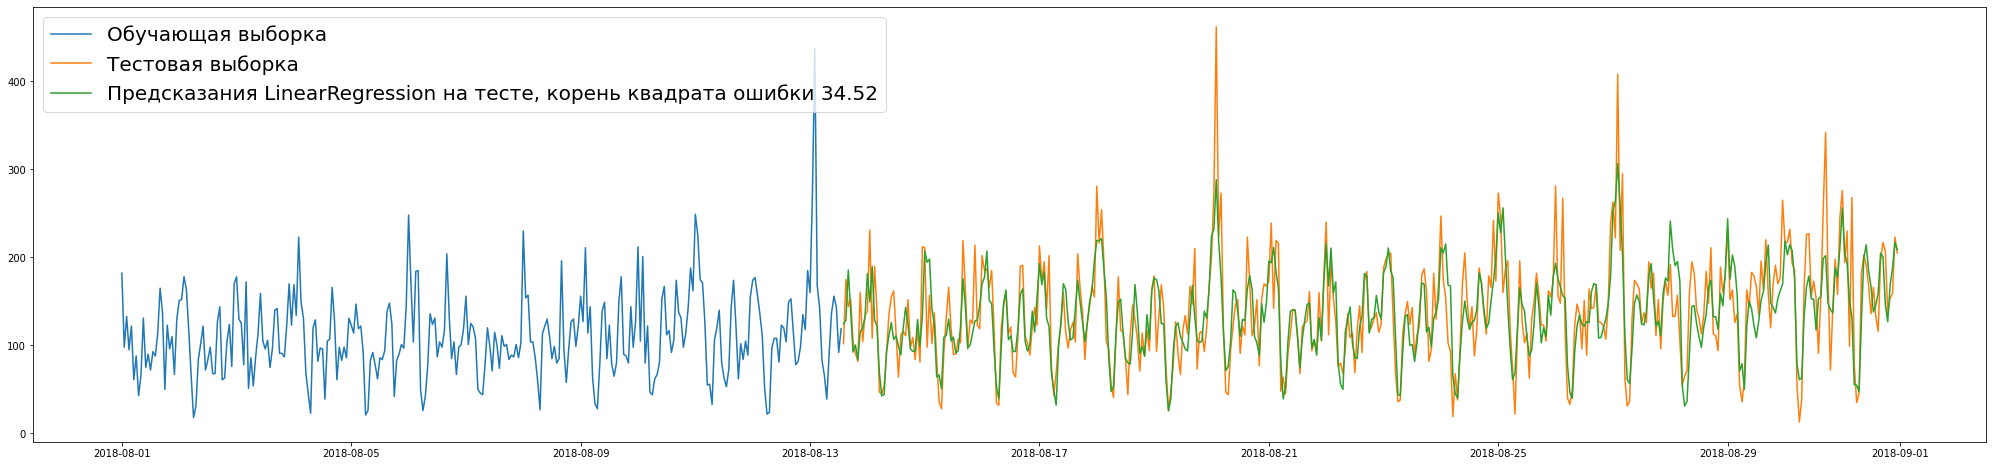

In [22]:
plt.figure(figsize=(35,8))
plt.plot(train['2018-08-01':]['num_orders'], label='Обучающая выборка')
plt.plot(test.index,test['num_orders'], label='Тестовая выборка')
plt.plot(test.index, pred_valid, label='Предсказания LinearRegression на тесте, корень квадрата ошибки {:.2f}'.format(rmse_lr))
plt.legend(loc='upper left',fontsize=20);

### LGBMRegressor

Обучим модель по дефолту

In [23]:
%%time
quantity_lag = list(range(1,336,48))
time_window = list(range(1,48,12))

best_rmse =30000
best_lag =0
best_time_window = 0
print('Ждать, ждать, не пережать 2-3 минуты')
for lag in quantity_lag:
    for window in time_window:
        train,test,features_train, target_train, features_test, target_test = data_prepare(data,lag,window)
        lgbm_reg = LGBMRegressor(random_state=393)
        rmse_lgbm_cv= cross_val_score(lgbm_reg, features_train,target_train,n_jobs = -1, cv=tscv,scoring = 'neg_root_mean_squared_error').mean()*(-1)                 
#         print('Корень среднего квадрата ошибки {:.2f}'.format(rmse_lgbm_cv),  'Количество временных лагов {}'.format(lag),'Временное окно {},ч'.format(window) )
        if rmse_lgbm_cv <= best_rmse:
            best_rmse =rmse_lgbm_cv
            best_lag = lag
            best_time_window =window
        
    
print('Лучшие показатели: RMSE={:.2f}'.format(rmse_lgbm_cv),'Количество временных лагов {}'.format(best_lag),'Временное окно {},ч'.format(best_time_window))

Ждать, ждать, не пережать 2-3 минуты
Лучшие показатели: RMSE=22.30 Количество временных лагов 193 Временное окно 25,ч
Wall time: 1min 59s


Осуществим подбор параметров

In [24]:
%%time
train,test,features_train, target_train, features_test, target_test = data_prepare(data,193,25)
regressor = LGBMRegressor(random_state=393) 
params = [{'n_estimators':list(range(100,400,100)), 
                'learning_rate':[0.01,0.1,0.3],
                'num_leaves':list(range(10,50,10))}]
    
print('Ждать невозможно лишь тогда, когда ничего не делаешь. Ожидайте, идет подгонка лучших параметров 3-5 мин')
clf = GridSearchCV(regressor, params, scoring='neg_root_mean_squared_error',n_jobs = -1,cv=tscv)
clf.fit(features_train,target_train)
print("Лучшие параметры:",clf.best_params_)
print('Наименшая ошибка лучшей модели', clf.best_score_*-1)

Ждать невозможно лишь тогда, когда ничего не делаешь. Ожидайте, идет подгонка лучших параметров 3-5 мин
Лучшие параметры: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 10}
Наименшая ошибка лучшей модели 21.945071238499427
Wall time: 4min 18s


Проверка модели на тесте

In [25]:
lgbm_reg = LGBMRegressor(random_state=393,learning_rate=0.1, n_estimators = 100, num_leaves= 10).fit(features_train,target_train)
predictions = lgbm_reg.predict(features_train)
predictions_test_lgbm = lgbm_reg.predict(features_test)
rmse_lgbm = mean_squared_error(predictions_test_lgbm,target_test,squared=False)
print("RMSE тестовой выборки: ", rmse_lgbm )

RMSE тестовой выборки:  36.666466085308244


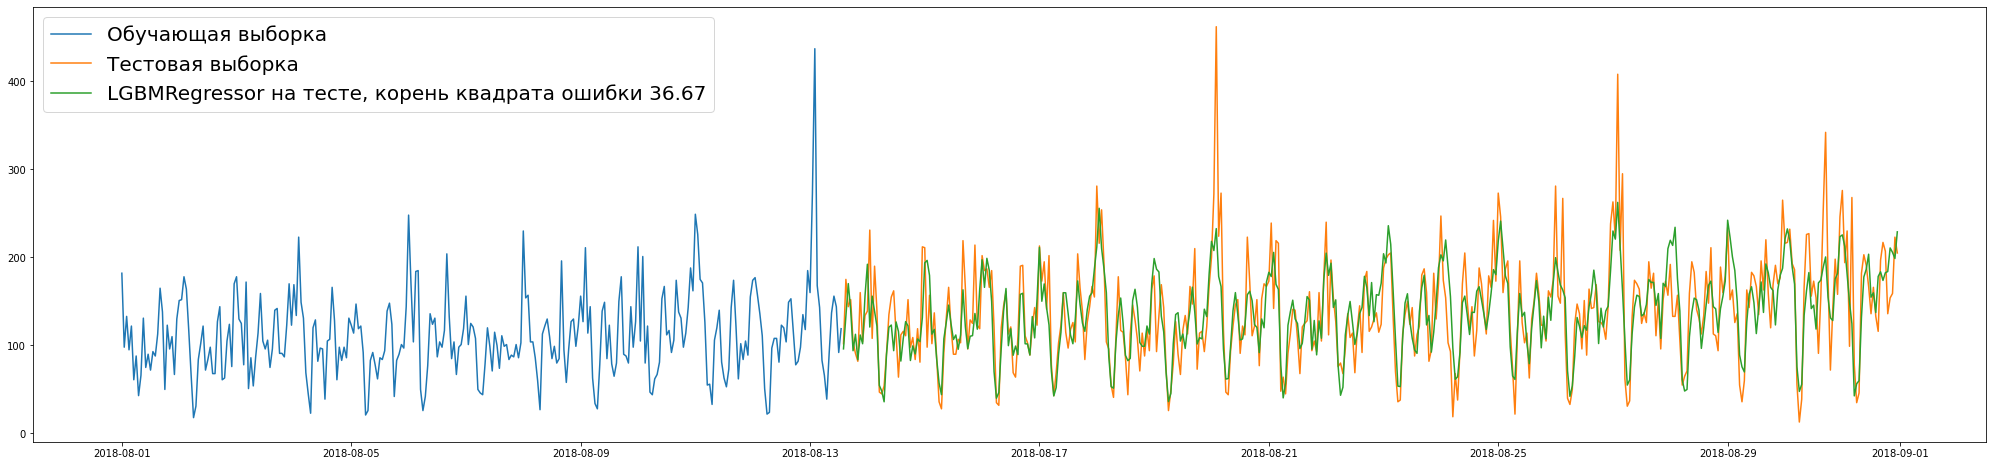

In [26]:
plt.figure(figsize=(35,8))
plt.plot(train['2018-08-01':]['num_orders'], label='Обучающая выборка')
plt.plot(test.index,test['num_orders'], label='Тестовая выборка')
plt.plot(test.index, predictions_test_lgbm, label='LGBMRegressor на тесте, корень квадрата ошибки {:.2f}'.format(rmse_lgbm))
plt.legend(loc='upper left',fontsize=20);

### CatBoostRegressor

Оставим параметры модели CatBoostRegressor по умолчанию 

In [27]:
%%time
train,test,features_train, target_train, features_test, target_test = data_prepare(data,108,25)
booster = CatBoostRegressor(logging_level='Silent')
cb_rmse= cross_val_score(booster, features_train,target_train,n_jobs = -1, cv=tscv,scoring = 'neg_root_mean_squared_error').mean()*(-1)
print("RMSE трейн выборки: {:.2f}".format(cb_rmse))

RMSE трейн выборки: nan
Wall time: 1min 46s


In [28]:
booster = CatBoostRegressor(logging_level='Silent').fit(features_train, target_train)
cb_test_preds = booster.predict(features_test)
cb_rmse_test = mean_squared_error(cb_test_preds,target_test,squared=False)
print("RMSE тестовой выборки: {:.2f}".format(cb_rmse_test))

RMSE тестовой выборки: 37.83


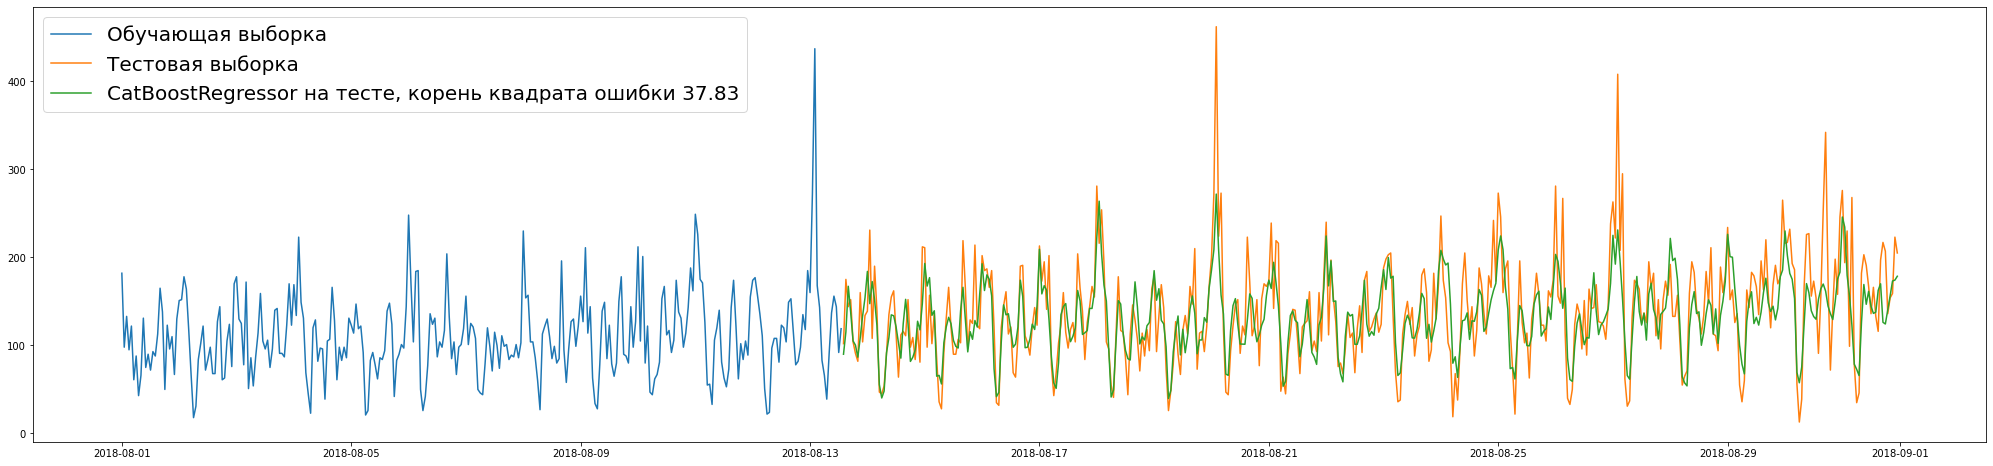

In [29]:
plt.figure(figsize=(35,8))
plt.plot(train['2018-08-01':]['num_orders'], label='Обучающая выборка')
plt.plot(test.index,test['num_orders'], label='Тестовая выборка')
plt.plot(test.index, cb_test_preds, label='CatBoostRegressor на тесте, корень квадрата ошибки {:.2f}'.format(cb_rmse_test))
plt.legend(loc='upper left',fontsize=20);

###  Модель по медиане

In [30]:
pred_median = np.ones(target_test.shape) * target_test.median()
rmse_median = mean_squared_error (target_test,pred_median,squared=False)
print("RMSE:",rmse_median)

RMSE: 58.7266464607412


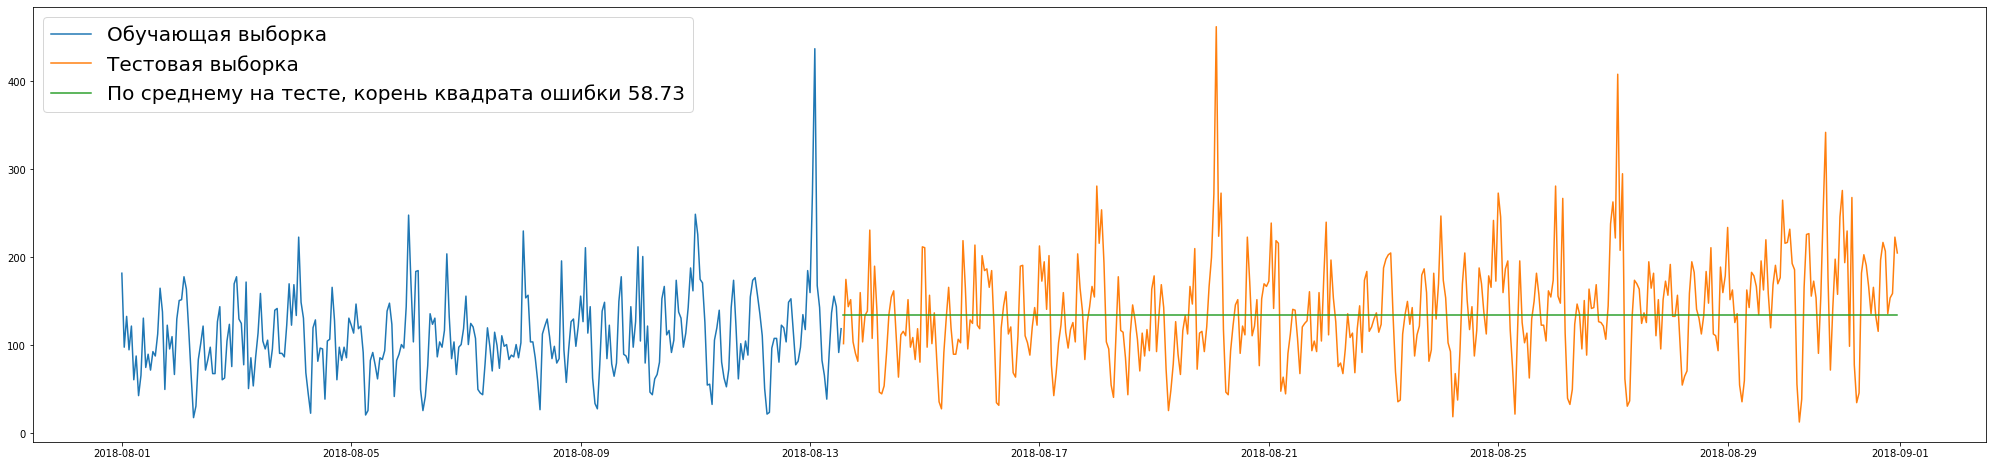

In [31]:
plt.figure(figsize=(35,8))
plt.plot(train['2018-08-01':]['num_orders'], label='Обучающая выборка')
plt.plot(test.index,test['num_orders'], label='Тестовая выборка')
plt.plot(test.index, pred_median, label='По среднему на тесте, корень квадрата ошибки {:.2f}'.format(rmse_median))
plt.legend(loc='upper left',fontsize=20);

**Комментарий**: ровно, чётко, красиво

### Модель предыдущим значением ряда

In [32]:
pred_previous = target_test.shift(fill_value = target_test.iloc[-1])
rmse_previous  = mean_squared_error (target_test,pred_previous,squared=False)
print("RMSE:",rmse_previous)

RMSE: 59.054503546641314


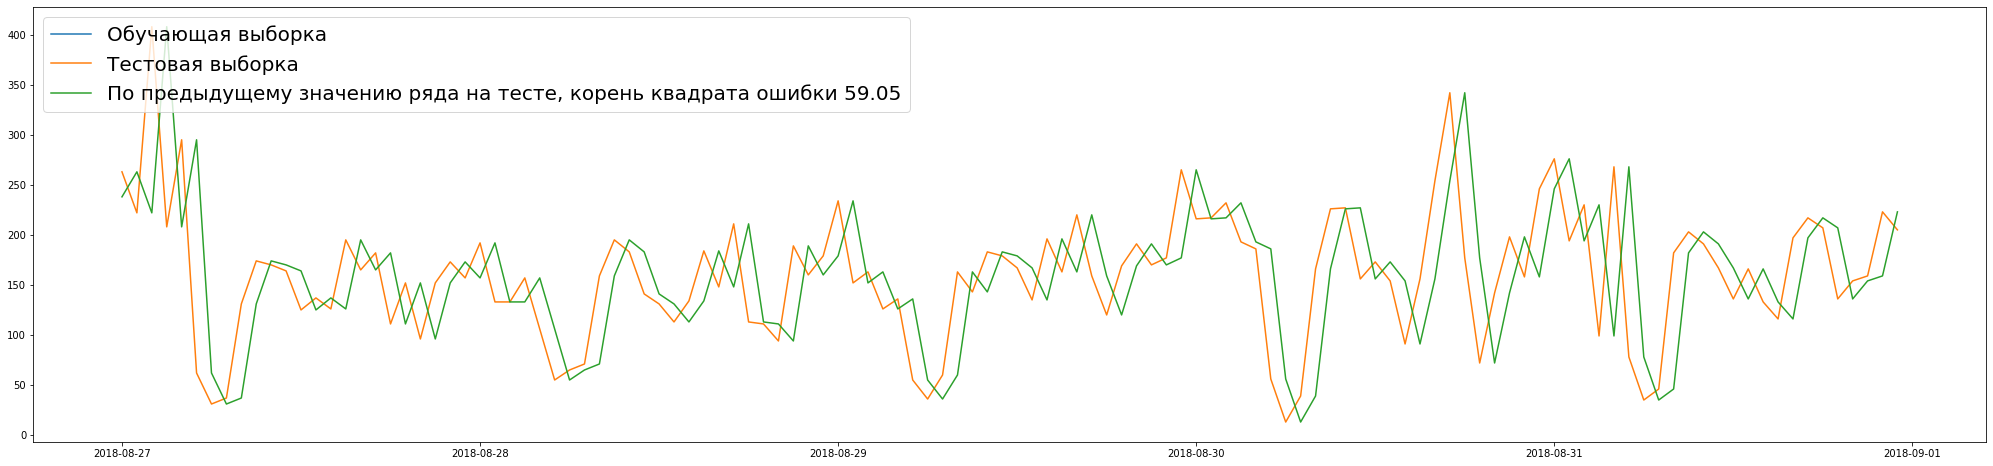

In [33]:
plt.figure(figsize=(35,8))
plt.plot(train['2018-08-27':]['num_orders'], label='Обучающая выборка')
plt.plot(test['2018-08-27':]['num_orders'], label='Тестовая выборка')
plt.plot(pred_previous['2018-08-27':], label='По предыдущему значению ряда на тесте, корень квадрата ошибки {:.2f}'.format(rmse_previous))
plt.legend(loc='upper left',fontsize=20);

# Вывод

1. По результатам работы рассмотрены 5 моделей. По трем моделям получилось достичь целевого показателя по заданной метрике RMSE, которая должна быть менее 48.
2. Лучшее качество метрики показала модель Линейная регрессия RMSE = 34.52
3. Хуже всего модели справлялись с резкими выбросами, здесь требуется более детально рассматривать причины аномальных отклонений, возможно, это праздничные дни и прочие.
4. Важным критерием для оценки стало создание лаговых переменных


In [34]:
pivot_table = pd.DataFrame(data=[rmse_lr, rmse_lgbm, cb_rmse_test, rmse_median, rmse_previous],
                       columns=['RMSE'],
                      index=['Линейная регрессия', 'Light_GBM', 'CatBoost','Медианное', 'Предыдущее значение'])
pivot_table.sort_values('RMSE')

,RMSE
Линейная регрессия,34.52
Light_GBM,36.67
CatBoost,37.83
Медианное,58.73
Предыдущее значение,59.05
